<a href="https://colab.research.google.com/github/Camipinto/Laboratorio-de-Programacion-Cientifica-para-Ciencia-de-Datos/blob/main/Proyecto/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto final MDS7202-1 2022-2
***El Desafío de Don Rene***

### Cuerpo docente MDS7202: Laboratorio de Programación Científica para Ciencia de Datos
**Profesores:** Matías Rojas - Mauricio Araneda<br/>
**Prof. Auxiliar:** Ignacio Meza<br/>
**Ayudante:** Rodrigo Guerra

### Integrantes y repositorio del proyecto
***Integrantes***: Camila Pinto - Camilo Ramírez<br/>
***URL repositorio:*** https://github.com/Camilormz/MDS7202-labs

## Introducción

Con el objetivo de predecir el éxito de nuevos videojuegos para asesorar inversionistas de la industria desde la evidencia empírica se resolverán 2 problemas:

- Encontrar un modelo óptimo de clasificación de las evaluaciones de los jugadores (Positivo, Negativo, etc).\
Se evaluará el desempeño de los modelos observando métricas de evaluación como $precision$ , $recall$ y se decidirá cuál es el más cercano al óptimo en base a $f_1-score $ 

- Predecir las potenciales ventas del juego con un modelo de regresión.
Se compararán los modelos de regresión en base al $R^2$ que entreguen y así poder elegir el mejor modelo para predecir.

Para resolver ambos problemas se cuenta con un dataset de entrenamiento, que cuenta con las columnas target de los problemas planteados además de los atributos, este se usará para entrenar y validar los modelos propuestos 

Además se cuenta con un dataset de testeo que contiene solo los atributos. A partir de estos datos se testearán los modelos escogidos para evaluar sus desempeños.

En primer lugar se debe explorar el dataset, para entender la naturaleza de los datos, identificar posibles errores, reconocer patrones, entre otros.
A partir de esta exploración se decide realizar las siguientes transformaciones:
- No considerar en los modelos columnas de texto que describen nombres como `name`, `developer` y `publisher`.
-  Transformar la columna `release_date` para obtener columnas del día y mes de lanzamiento que consideren la periodicidad de ambas.
- Transformar las columnas que cuentan con múltiples categorías a múltiples columnas con las categorías desagregadas.
- Definir un hiperparámetro del % de desbalance soportado que se pueda modificar en cada modelo, dado el alto desbalance de clases de algunos atributos.
- Hacer codificación de la columna de texto que se mantiene (`short_description`) mediante embedding. 

Luego de estas transformaciones y de explorar disitntos modelos se logra clasificar las evaluaciones con $XX$, logrando un $f_1-score$ de XX para el problema de clasificación y se logra predecir las ventas con $XX$ para el problema de regresión, logrando un $R^2$ de XX. 

In [ ]:
%%capture
!pip install -U sentence-transformers
!pip install matplotlib==3.4.0
!pip install pickle5
!pip install optuna

In [ ]:
# Carga de librerías necesarias para la ejecución del proyecto
from sklearn.experimental import enable_halving_search_cv

from pandas.core.indexes.accessors import DatetimeProperties
from sklearn.model_selection import train_test_split
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from pandas.core.series import Series as PandasSeries
from pandas.core.frame import DataFrame as PandasDF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, r2_score,\
                            mean_squared_error, f1_score, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from numpy.typing import ArrayLike
from sklearn.svm import SVC, SVR
from typing import Optional, List, Union, Dict, Any, Tuple

import matplotlib.pyplot as plt
import plotly.express as px
import pickle5 as pickle
import pandas as pd
import numpy as np

import optuna

## Análisis exploratorio de datos - EDA

In [ ]:
%%capture
# Descarga directa de los datos desde Internet
!gdown 1j6OAS2dlZ_e7BwV84UfJNJHMo5AkdF4v  # Datos de train
!gdown 1pmZIFMYi-jMGKiBQxELNvtdCHAyXtaq0  # Datos de test

In [ ]:
# Carga de datos en dataframes
with open("train.pickle", "rb") as train_file:
    df_data: PandasDF = pickle.load(file=train_file)
with open("test.pickle", "rb") as test_file:
    df_test: PandasDF = pickle.load(file=test_file)

In [ ]:
# Carga del modelo de embeddings
embedding_model: SentenceTransformer = SentenceTransformer(
    model_name_or_path='all-MiniLM-L6-v2'
)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Se extrae una muestra de cada *dataframe* a modo de visualizar sus contenidos, y además se extrae el tamaño del mismo a modo de identificar el orden de magintud de datos y atributos presentes.

In [ ]:
df_data.head(n=3)

,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,tags,achievements,average_playtime,price,short_description,estimated_sells,rating
0,An Aspie Life,2018-03-29,1,Bradley Hennessey;Joe Watson,EnderLost Studios,windows,0,Single-player;Steam Achievements,Adventure;Casual;Free to Play;Indie;Simulation,Free to Play;Adventure;Indie,23,0,0.00,One day your roommate Leaves for no reason. Yo...,3914,Mixed
1,GhostControl Inc.,2014-06-06,1,bumblebee,Application Systems Heidelberg,windows;mac;linux,0,Single-player;Steam Achievements;Steam Trading...,Casual;Indie;Simulation;Strategy,Turn-Based;Indie;Simulation,53,65,10.99,Manage a team of ghosthunters and free London ...,10728,Mixed
2,Deponia,2012-08-06,1,Daedalic Entertainment,Daedalic Entertainment,windows;mac;linux,0,Single-player;Steam Achievements;Steam Trading...,Adventure;Indie,Adventure;Point & Click;Comedy,19,217,6.99,"In Deponia, the world has degenerated into a v...",635792,Positive


In [ ]:
df_test.head(n=3)

,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,tags,achievements,average_playtime,price,short_description
0,Frog Climbers,2016-10-06,1,TeamCrew,Dear Villagers,windows,0,Single-player;Local Multi-Player;Shared/Split ...,Indie,Indie;Local Multiplayer;Funny,0,239,4.99,Climb mountains. Beat your friends. Be a douch...
1,Aztaka,2009-11-05,1,Citeremis Inc.,Citeremis Inc.,windows;mac,0,Single-player,Action;RPG;Indie,RPG;Action;Indie,0,0,3.99,"Inspired by Aztec legend, this action/rpg side..."
2,Assault Spy / アサルトスパイ,2018-10-02,1,Wazen,"NIS America, Inc.",windows,0,Single-player;Full controller support,Action;Indie,Action;Indie;Character Action Game,28,0,24.99,"Dash, evade, and smash your way to the truth a..."


Como se puede ver, el *dataframe* de *test* tiene los mismos atributos que el *dataframe* de datos, con la excepción de que carece de los atributos `estimated_sells` y `rating`, los cuales son los *target* de los problemas de regresión y clasificación respectivamente.

Respecto a los atributos mismos, se puede ver que son 16, esto incluye los dos atributos *target* que no serán considerados como parte de la entrada del modelo de regresión, ni de clasificación; estos se pueden ver que son altamente variados en su contenido y tipo, lo cual motiva la ejecución de un análisis univariado al detalle.

In [ ]:
# Función que será de utilidad para el análisis univariado
def execute_univariate_analysis(attribute_name: str,
                                analysis_mode: str) -> None:
    """
    Perform an univerate analysis over the train dataframe for an specified
    attribute and analysis mode

    Parameters
    ----------
    attribute_name
        Name of the attribute to analyze
    analysis_mode
        Identifier of the analysis mode to be performed
    
    Raises
    ------
    ValueError
        If the stated attribute_name is not an attribute of the train
        dataframe, or if the stated analysis_mode is not available
    """
    def _plot_value_counts(
        s: PandasSeries, max_values: int = 20,
        plot_title: Optional[str] = None, plot_subtitle: Optional[str] = None,
        plot_xlabel: Optional[str] = None, sort_index: bool = False,
        ax: Optional[plt.Axes] = None
    ) -> None:
        """
        Auxiliar function that plots the value counts for the series

        Parameters
        ----------
        s
            Series to plot
        max_values
            Maximum values to plot
        plot_title
            Optional title for the plot
        plot_subtitle
            Optional subtitle for the plot
        plot_xlabel
            Optional xlabel for the plot
        sort_index
            Boolean flag that indicates if the indexes should be sorted or not
        ax
            Ax to add the plot
        """
        val_count: PandasSeries = s.value_counts()
        if sort_index:
            val_count = val_count.sort_index()
        unique_val_count: PandasSeries = val_count[:max_values]
        unique_counts: np.ndarray = unique_val_count.values
        max_count: float = unique_counts.max()
        min_count: float = unique_counts.min()
        # If there is much category disparity, a log scale is set on y axis
        log_flag: bool = bool(max_count/min_count > 10)
        # The plots title depends on if there is a sample considered or not
        plot_title: str
        if plot_title is None:
            if len(s.unique()) <= max_values:
                plot_title = "Conteo de datos por valor"
            else:
             plot_title = (f"Conteo de datos para los {max_values} "
                            "valores más numerosos")
        if plot_subtitle is not None:
            plot_title = f"{plot_title}\n{plot_subtitle}"
        if plot_xlabel is None:
            plot_xlabel = "Valor de atributo"
        val_histogram: plt.Axes = unique_val_count.plot.bar(
            title=plot_title, xlabel=plot_xlabel, ylabel="Conteo de datos",
            logy=log_flag, ax=ax
        )
        val_histogram.bar_label(container=val_histogram.containers[0])
        if log_flag:
            val_histogram.set_ylim(bottom=min_count/2.0, top=max_count*2.0)
        val_histogram.grid(axis='y')
    
    def _plot_histogram(s: PandasSeries, plt_ax: plt.Axes,
                        x_label: Optional[str] = None,
                        title: Optional[str] = None, y_log: bool = False):
        """
        Plots an histogram that has common properties to various analysis modes

        Parameters
        ----------
        s
            Series to plot
        x_label
            X axis label, if None, the default label will be used
        title
            Plot title, if None, the default title will be used
        y_log
            Boolean flag that indicates if the y axis is on a logaritmical
            scale or not
        """
        s.hist(bins=100, ax=plt_ax)
        if y_log:
            plt_ax.set_yscale(value="log")
        plt_ax.set_title(
            label="Histograma de valores numéricos" if title is None else title
        )
        plt_ax.set_xlabel(xlabel="Valor" if x_label is None else x_label)
        plt_ax.set_ylabel(ylabel="Frecuencia")

    # Main routine of the function
    try:
        series: PandasSeries = df_data[attribute_name]
    except KeyError:
        raise ValueError("The stated attribute name is not an attribute of "
                         "the dataframe to analyze")
    print(f"Análisis del atributo '{attribute_name}'")
    print(f"Tipo de atributo: '{series.dtype}'\n")
    print(f"Cantidad de datos nulos: {series.isna().sum()}")
    unique_values: np.ndarray = series.unique()

    # Analysis for categorical variables
    if analysis_mode == "categorical":
        total_categories: int = len(unique_values)
        print(f"Cantidad de categorías totales: {total_categories}")
        # Doesn't perform further analysis if the category is not informative
        if total_categories == len(series):
            print(f"\nCada dato del datafame tiene un valor único\n")
            print("Muestra aleatoria de los valores de la clase:")
            print(series.sample(n=10, random_state=1234))
        else:  # There are less categories than the amount of data
            print(f"\nCategorías presentes:")
            print(unique_values)
            _plot_value_counts(s=series)
    
    # Analysis for multicategory variables, these variables has values that
    # contains ; separated elements
    elif analysis_mode == "multicategory":
        total_entries: int = len(unique_values)
        print(f"Cantidad total de entradas distintas: {total_entries}")
        split_series: PandasSeries = series.apply(lambda x: x.split(';'))
        exploded_series: PandasSeries = split_series.explode()
        unique_series: PandasSeries = exploded_series.unique()
        print(f"\nCategorías presentes: {len(unique_series)}")
        print(unique_series)
        fig: plt.Figure
        ax: List[plt.Axes]
        fig, ax = plt.subplots(ncols=3, figsize=(28, 4))
        _plot_value_counts(
            s=series, ax=ax[0],
            plot_subtitle="(Valores de atributo sin disgregar)"
        )
        _plot_value_counts(
            s=split_series.apply(lambda x: len(x)), ax=ax[1], sort_index=True,
            plot_title="Cantidad de datos con $n$ valores de atributo a "
                       "disgregar",
            plot_xlabel="Cantidad $n$ de categorías"
        )
        _plot_value_counts(
            s=exploded_series, ax=ax[2],
            plot_subtitle="(Valores de atributo disgregados)"
        )
    
    elif analysis_mode in ["datetime", "integer", "float"]:
        print(f"Cantidad de datos duplcados: {len(series)-len(unique_values)}")
        fig: plt.Figure
        ax: Union[plt.Axes, List[plt.Axes]]
        hist_ax: plt.Axes
        if analysis_mode == "float":
            fig, ax = plt.subplots(ncols=1, figsize=(8, 4))
            hist_ax = ax
        else:
            fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
            hist_ax = ax[1]
            _plot_value_counts(s=series, ax=ax[0])
        if analysis_mode == "datetime":
            _plot_histogram(s=series.astype("datetime64"), plt_ax=hist_ax,
                            title="Histograma de valores de fecha",
                            x_label="Fecha")
        else:
            _plot_histogram(s=series, plt_ax=hist_ax, y_log=True)
    
    else:
        raise ValueError(f"The stated analysis mode '{analysis_mode}' "
                          "is not available")

### Análisis univariado
El análisis univariado considera 5 modos de categorías.
- `categorical` se aplica para atributos que se observan categóricos.
- `multicategory` se aplica para atributos que se observa que contienen una lista de categorías como valor, según el formato siguiente: `categoría 1;categoría 2; ... ;categoría n`. Para estos atributos en particular, se aplica un análisis de categorías conjuntas (considerando `cat1;cat2;...;catn` como una clase única), realizando un conteo de cuántas categorías (valor de `n`) a las que pertenece cada dato en particular; y un análisis disgregado (consdierando `cat1`, `cat2`, ..., `catn` como distintas categorías).
- `datetime` se aplica para categorías que se observan con formato tipo fecha.
- `integer` se aplica para categorías con valores numéricos enteros.
- `float` se aplica para categorías con valores numéricos en punto flotante.

> **Importante:** Para los atributos de tipo `multicategory`, se realizará una transformación de disgregación por categorías, dónde para cada categoría se asignará valores *booleanos* `True` o `False`, dependiendo si la categoría está incluída o no en la lista que define este atributo.

> Como ejemplo, si un atributo tiene como posibles categorías `c1`, `c2`, `c3`, `c4` y `c5`; se crearán atributos con estos nombres (`c1` a `c5`), y si existe un dato que tenga por valor (por ejemplo) `c1;c4;c5`, entonces los valores de las categorías correspondientes serán `True`, `False`, `False`, `True` y `True` respectivamente.

> Esta transformación mencionada se denominará **multicategórica**.

> **Adicionalmente:** Existen atributos de valores booleanes (`True` o `False`), los cuales serán considerados solamente si su desbalance está por debajo de determinado umbral. Este criterio (umbral de porcentaje de datos que pertenecen a la clase matoritaria) será considerado un **hiperparámetro** del *pipeline* a construir para este problema.

#### Análisis de atributo `name`

In [ ]:
execute_univariate_analysis(attribute_name="name", analysis_mode="categorical")

Análisis del atributo 'name'
Tipo de atributo: 'object'

Cantidad de datos nulos: 0
Cantidad de categorías totales: 7881

Cada dato del datafame tiene un valor único

Muestra aleatoria de los valores de la clase:
4109                             WIN THE GAME!
5464          Assassin's Creed® III Remastered
7228                                   Besiege
7333    N.E.R.O.: Nothing Ever Remains Obscure
4251                   Warhammer: Vermintide 2
4470                                   CLANNAD
3134                                    DOOM 3
4422               J.U.L.I.A.: Among the Stars
6481             Mhakna Gramura and Fairy Bell
4769                            Critter Crunch
Name: name, dtype: object


> El atributo `name` contiene el título del videojuego, cada videojuego del *dataset* contiene un `name` único, por lo cual no es un atributo categórico útil para ser utilizado en un clasificador. Por otro lado, debido a que los títulos son textos en lenguaje natural, se podría considerar aplicar técnicas de NLP a modo de extraer información del mismo; sin embargo, la información que otorga el título por si solo, es bastante escaza.

> Por los motivos mencionados previamente, se decide prescindir de este atributo en la generación de modelos.


Análisis de atributo `release_date`

Análisis del atributo 'release_date'
Tipo de atributo: 'object'

Cantidad de datos nulos: 0
Cantidad de datos duplcados: 5630


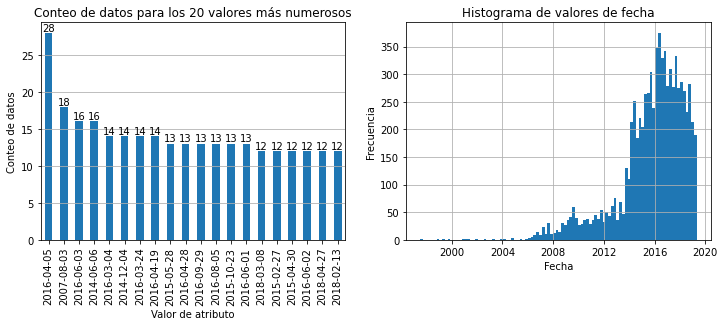

In [ ]:
execute_univariate_analysis(attribute_name="release_date",
                            analysis_mode="datetime")

> El atributo `release_date` contiene la fecha de lanzamiento del videojuego, en particular se puede ver como existe una mayor cantidad de muestras en el intervalo 2014 - 2020, y que en general existen fechas con una relativamente elevada cantidad de lanzamientos.

> Se asume que esta variable es irrelevante a efectos del *ranking* que le otorgan los usuarios (problema de clasificación).

> Respecto al problema de regresión, es decir, si este atributo incide en las ventas estimadas, se puede decir que sí. A estos efectos, existen fenómenos de larga y corta temporalidad que pueden incidir en las ventas de un videojuego. Por un lado, la situación macroeconómica de determinada época puede incidir en las ventas, pero esto no es algo que el modelo pueda aprender, ya que este contexto no es parte del *dataset*. Lo que sí se puede considerar es la temporalidad de corto plazo, es decir, el día y el mes de lanzamiento; los cuáles pueden ser relevantes en cuanto a las ventas estimadas del videojuego.

> Lo anterior induce a considerar el día y el mes respecto al problema de regresión, dado que estas variables son *circulares*, es decir, el último día de un mes o el último mes de un año son el día previo al primer día del siguiente mes o el primer mes del siguiente año respectivamente, se puede definir una transformación tipo seno y coseno para cada una de estas variables.

Análisis de atributo `english`

Análisis del atributo 'english'
Tipo de atributo: 'int64'

Cantidad de datos nulos: 0
Cantidad de categorías totales: 2

Categorías presentes:
[1 0]


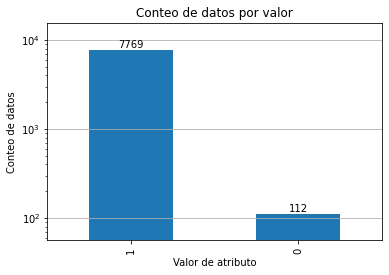

In [ ]:
execute_univariate_analysis(attribute_name="english",
                            analysis_mode="categorical")

> El atributo `english` corresponde a uno categórico que indica si el juego está disponible en inglés o no (sin perjuicio que sea multilenguaje). Si bien esta es una variable que puede inducir fuertemente las ventas (no así el *ranking* necesariamente), se puede ver que las clases están extremadamente desbalanceadas (casi dos órdenes de magnitud).

> Sin perjuicio de lo anterior, el umbral de desbalance seleccionado como hiperparámetro será determinante para decidir si considerar o no, este atributo en el modelo.

Análisis de atributo `developer`

Análisis del atributo 'developer'
Tipo de atributo: 'object'

Cantidad de datos nulos: 0
Cantidad total de entradas distintas: 5365

Categorías presentes: 5617
['Bradley Hennessey' 'Joe Watson' 'bumblebee' ... '9heads Game Studios'
 'ARES Inc.' 'The Munky']


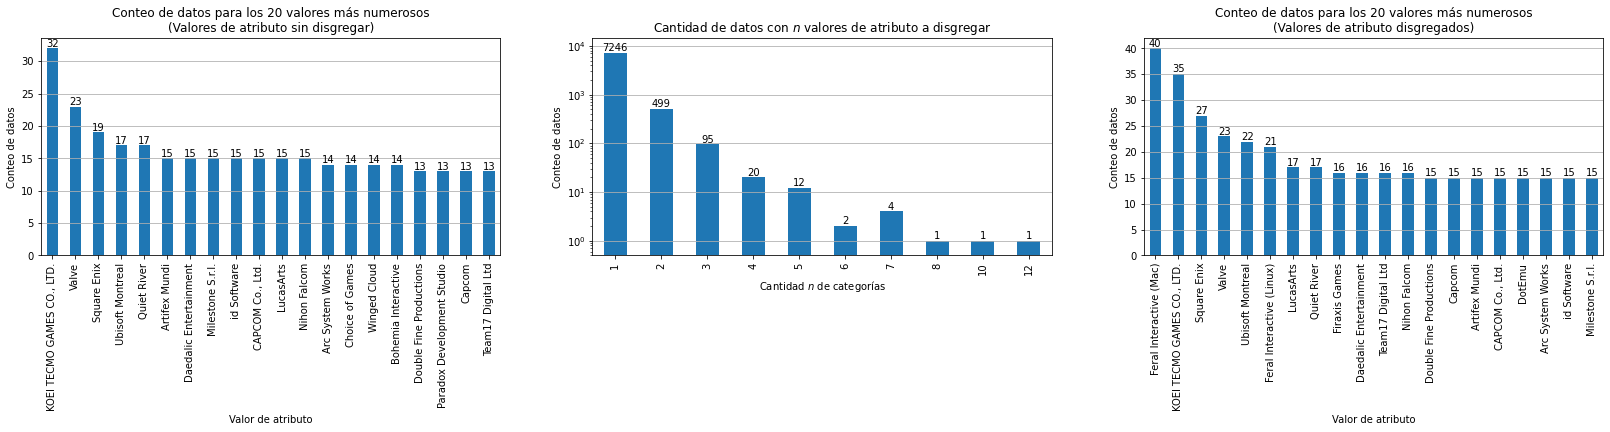

In [ ]:
execute_univariate_analysis(attribute_name="developer",
                            analysis_mode="multicategory")

> El atributo `developer` contiene una lista de nombres (o pseudónimos) de las personas, grupos o empresas (entidades) que desarrollaron el videojuego. Esta lista como se puede ver, en una gran cantidad de datos (92% aprox.) contiene solamente la identificación de una entidad de desarrollo.

> El nombre de los desarrolladores, sin un contexto adicional, tienen poco valor informativo respecto a las proyecciones del videojuego, dado que en sí mismos son poco descriptivos, al igual o peor que el atributo `name`, por lo que realizar NLP sobre estre atributo queda descartado.

> Respecto a su naturaleza categórica, se puede ver que la entidad que ha desarrollado más videojuegos, según el análisis disgregado, es `Feral Interactive (Mac)` con 40 videojuegos, lo cual implica una cantidad de muestras muy pequeña por categoría, siendo 5617, se considera que no hay datos suficientes para que un modelo de aprendizaje de máquinas logre aprender de estos atributos.

> Se realizará una transformación multicategórica sobre este atributo, pero debido a su alto desbalance, se requeriría un umbral de desbalance muy alto para permitir que algunos de los `developers` se consideren como atributo.

Análisis de atributo `publisher`

Análisis del atributo 'publisher'
Tipo de atributo: 'object'

Cantidad de datos nulos: 0
Cantidad total de entradas distintas: 3992

Categorías presentes: 3961
['EnderLost Studios' 'Application Systems Heidelberg'
 'Daedalic Entertainment' ... '9heads Game Studios' 'ARES Inc.'
 'The Munky']


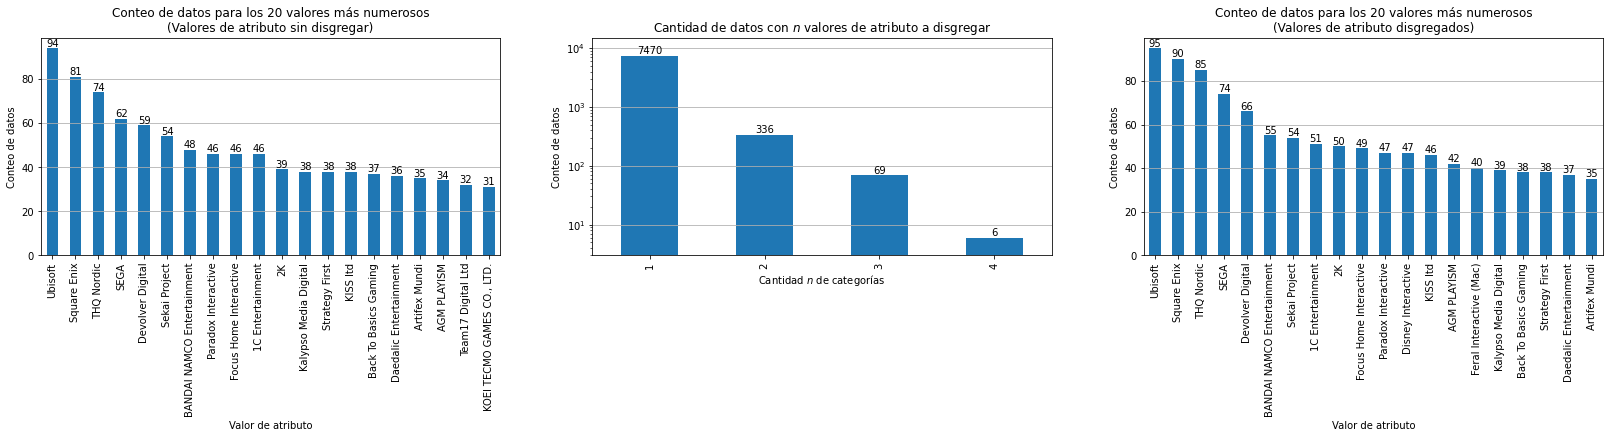

In [ ]:
execute_univariate_analysis(attribute_name="publisher",
                            analysis_mode="multicategory")

> El atributo `publisher` contiene una lista de entidades que publicaron el videojuego.

> El análisis de este atributo desprende las mismas conclusiones que el atributo `developer`, dado que los nombres de los publicadores son poco descriptivos como para hacer análisis NLP, la cantidad de datos por entidad publicadora son pequeñas, y además, existe una gran cantidad de categorías únicas (3961).

> El tratamiento de este atributo será como multicategórico, al igual que el atributo `developer`.

Análisis de atributo `platforms`

Análisis del atributo 'platforms'
Tipo de atributo: 'object'

Cantidad de datos nulos: 0
Cantidad total de entradas distintas: 5

Categorías presentes: 3
['windows' 'mac' 'linux']


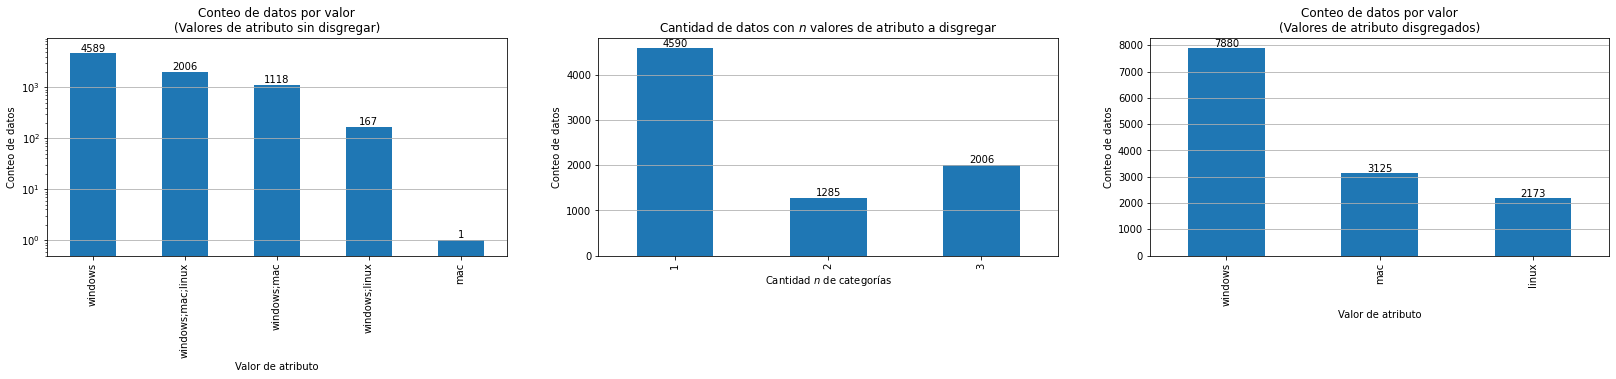

In [ ]:
execute_univariate_analysis(attribute_name="platforms",
                            analysis_mode="multicategory")

> El atributo `platforms` contiene una lista de plataformas en las cuales ha sido lanzado el videojuego. Estas plataformas son tres: `windows`, `mac` y `linux`.

> Cada plataforma corresponde a un conjunto de mercados en el cual el videojuego estará en venta; por lo cual este atributo es fundamental para estimar las ventas de un videojuego. Adicionalmente, no es posible descartar la dependencia estadística del segmento de consumidores de cada plataforma respecto a su experiencia con el juego, por lo cual también se podría considerar este atributo a la hora de resolver el problema de clasificación.

> A este atributo se le realizará una transformación multicategórica.

Análisis de atributo `required_age`

Análisis del atributo 'required_age'
Tipo de atributo: 'int64'

Cantidad de datos nulos: 0
Cantidad de categorías totales: 6

Categorías presentes:
[ 0 16 18 12  7  3]


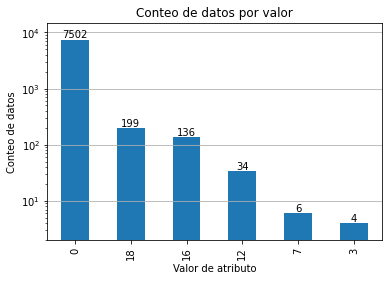

In [ ]:
execute_univariate_analysis(attribute_name="required_age",
                            analysis_mode="categorical")

> El atributo `required_age` contiene valores categóricos que indican la edad requerida para jugar un videojuego.

> Como se puede ver este atributo tiene 6 clases muy desbalanceadas, donde la clase más numerosa concentra el 95.2% de los datos. Este desbalance significativo induce a determinar la *no* consideración de este atributo en los modelos requeridos.

Análisis de atributo `categories`

Análisis del atributo 'categories'
Tipo de atributo: 'object'

Cantidad de datos nulos: 0
Cantidad total de entradas distintas: 1933

Categorías presentes: 29
['Single-player' 'Steam Achievements' 'Steam Trading Cards' 'Steam Cloud'
 'Stats' 'Multi-player' 'Online Multi-Player' 'In-App Purchases' 'Co-op'
 'Partial Controller Support' 'Steam Workshop' 'Full controller support'
 'Includes level editor' 'Commentary available' 'Local Multi-Player'
 'Shared/Split Screen' 'Steam Leaderboards' 'Cross-Platform Multiplayer'
 'VR Support' 'Online Co-op' 'Local Co-op' 'Captions available'
 'Valve Anti-Cheat enabled' 'Includes Source SDK' 'MMO'
 'Steam Turn Notifications' 'SteamVR Collectibles' 'Mods'
 'Mods (require HL2)']


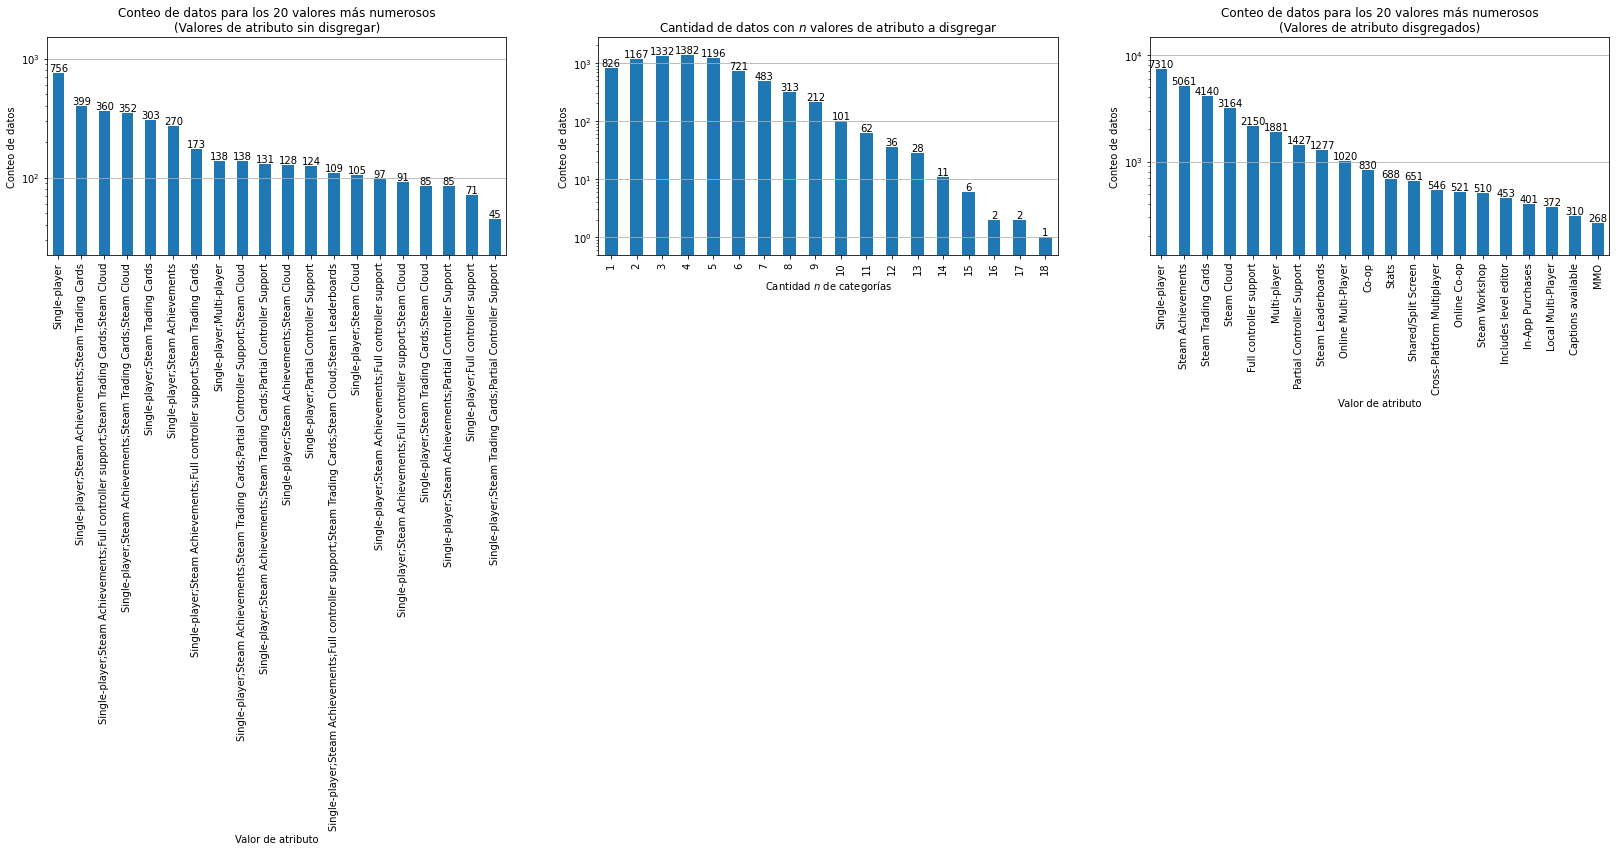

In [ ]:
execute_univariate_analysis(attribute_name="categories",
                            analysis_mode="multicategory")

> El atributo `categories` contiene una lista de categorías de videojuegos de las cuales el videojuego en cuestión es parte.

> Las 29 categorías contenidas en este atributo multicategórico determinan aspectos como la jugabilidad y los nichos de mercado a los cuáles el videojuego está apuntando. Lo mencionado hace explícita la relevancia de este atributo tanto para el problema de clasificación como de regresión.

> Por lo anterior, para este atributo se realizará la transformación multicategórica presentada al inicio de esta sección.

Análisis de atributo `genres`

Análisis del atributo 'genres'
Tipo de atributo: 'object'

Cantidad de datos nulos: 0
Cantidad total de entradas distintas: 844

Categorías presentes: 26
['Adventure' 'Casual' 'Free to Play' 'Indie' 'Simulation' 'Strategy'
 'Sports' 'RPG' 'Action' 'Violent' 'Gore' 'Early Access' 'Racing'
 'Massively Multiplayer' 'Animation & Modeling' 'Design & Illustration'
 'Education' 'Software Training' 'Utilities' 'Game Development' 'Nudity'
 'Video Production' 'Sexual Content' 'Web Publishing' 'Photo Editing'
 'Audio Production']


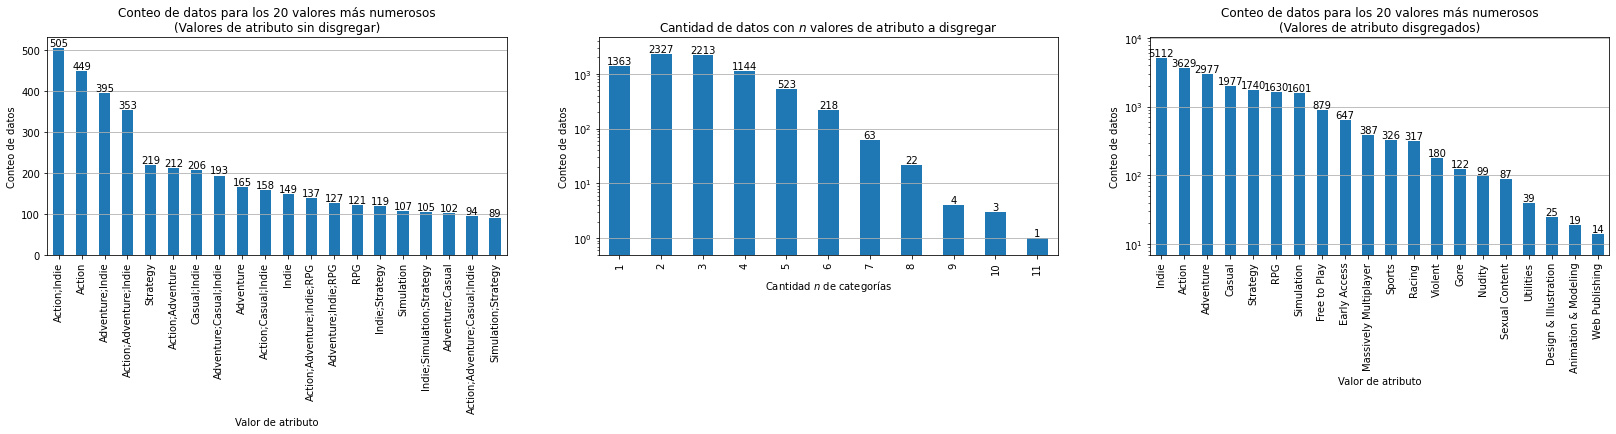

In [ ]:
execute_univariate_analysis(attribute_name="genres",
                            analysis_mode="multicategory")

> El atributo `genres` contiene una lista de géneros a los cuales el videojuego pertenece. Estas clasificaciones refieren a aspectos de jugabilidad de manera muy similar a como lo hace el atributo `categories`, con la diferencia que en `categories` el criterio para clasificar puede ser más tangencial a la propuesta central del videojuego (como se tiene o no logros en Steam), mientras que los géneros están más vinculados a esta propuesta central.

> A este atributo se le aplicará la transformación multicategórica comentada al inicio de esta sección.

Análisis de atributo `tags`

Análisis del atributo 'tags'
Tipo de atributo: 'object'

Cantidad de datos nulos: 0
Cantidad total de entradas distintas: 3981

Categorías presentes: 306
['Free to Play' 'Adventure' 'Indie' 'Turn-Based' 'Simulation'
 'Point & Click' 'Comedy' 'Multiplayer' 'Strategy' 'Casual' 'Sports'
 'Base-Building' 'Survival' 'Memes' 'Visual Novel' 'Horror' 'RPG'
 'Singleplayer' 'Puzzle' 'Anime' 'VR' 'Fighting' '2D Fighter' 'Clicker'
 'Action' 'Gore' 'Hidden Object' 'Early Access' 'MOBA' 'Racing' 'Music'
 'Baseball' 'Driving' 'Zombies' 'Survival Horror' 'World War II'
 'Card Game' 'Massively Multiplayer' 'Game Development'
 'Design & Illustration' 'Animation & Modeling' 'Puzzle-Platformer'
 'Female Protagonist' 'Noir' 'Arcade' 'Nudity' 'Sexual Content' 'Mature'
 'FPS' 'Medieval' 'City Builder' 'Retro' 'Time Management' 'Open World'
 'Exploration' 'Football' 'Great Soundtrack' 'Character Customization'
 'Atmospheric' 'World War I' 'Space' 'Cute' 'Board Game' 'Golf'
 'First-Person' 'Platformer' 'Flight

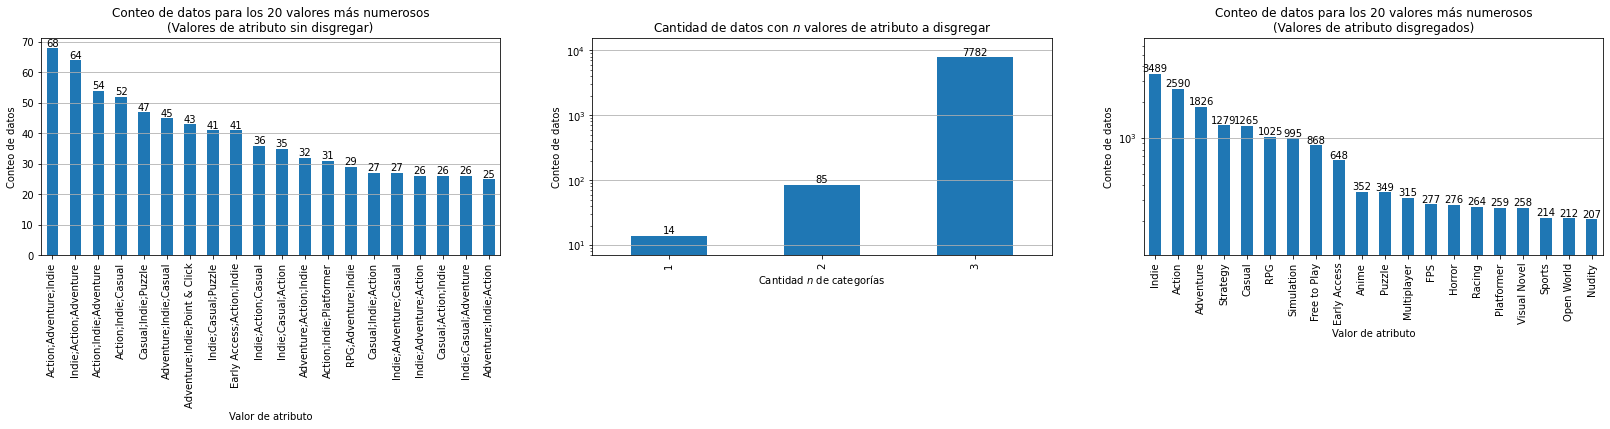

In [ ]:
execute_univariate_analysis(attribute_name="tags",
                            analysis_mode="multicategory")

Análisis de atributo `achievements`

> El atributo `tags` contiene una lista de etiquetas (*tags*) que identifica el publicador del videojuego, a modo de clasificarlo según elementos diferenciadores del mismo. Estos *tags* refieren a elementos de la jugabilidad, de la trama, o de características técnicas del videojuego.

> Al igual que los atributos `gategories` y `genres`, corresponde a un atributo bien informativo respecto al juego, por lo cual se le aplicará la transformación multicategórica.

Análisis del atributo 'achievements'
Tipo de atributo: 'int64'

Cantidad de datos nulos: 0
Cantidad de datos duplcados: 7601


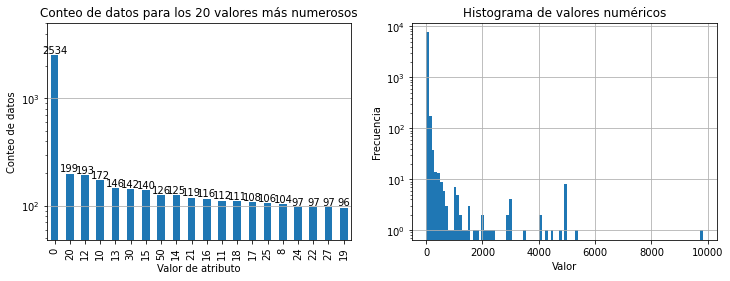

In [ ]:
execute_univariate_analysis(attribute_name="achievements",
                            analysis_mode="integer")

> El atributo `achievements` contiene un número entero que indica la cantidad de logros a completar que contiene el videojuego.

> Este valor puede incidir en la experiencia del usuario, ya que enriquece la misma en el sentido que le otorga más propósitos al jugador para jugar.

> Por lo anterior, esta variable numérica se considerará en ambos análisis, tanto en el problema de regresión como en el problema de clasificación. La transformación aplicada a este atributo corresponderá a un *Robust-Scaler*, esto ya que no se ve una distribución gaussiana de los valores, y se distingue la presencia de *outliers*.

Análisis de atributo `average_playtime`

Análisis del atributo 'average_playtime'
Tipo de atributo: 'int64'

Cantidad de datos nulos: 0
Cantidad de datos duplcados: 6624


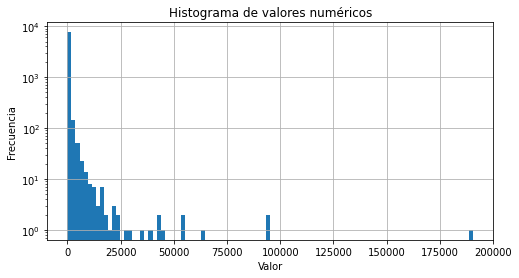

In [ ]:
execute_univariate_analysis(attribute_name="average_playtime",
                            analysis_mode="float")

> El atributo `average_playtime` contiene un número real que indica el tiempo estimado promedio que un jugador le dedicará al juego hasta explotar lo que el mismo ofrece, esto puede ser, terminar el modo historia, pasar una determinada cantidad de niveles u obtener una determinada cantidad de logros.

> Al igual que el atributo `achievements`, este puede incidir en la jugabilidad, por lo cual se considerará en ambos modelos; la transformación a aplicar es la de *Robust-Scaler* ya que se observan características de la distribución muy similares a lo observado para el atributo `achievements`.

Análisis de atributo `price`

Análisis del atributo 'price'
Tipo de atributo: 'float64'

Cantidad de datos nulos: 0
Cantidad de datos duplcados: 7719


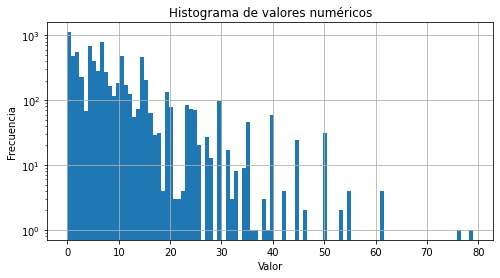

In [ ]:
execute_univariate_analysis(attribute_name="price", analysis_mode="float")

> El atributo `price` contiene el precio de venta del videojuego. Este claramente incide en las ventas estimadas, y además puede incidir en el *ranking* que le dan los jugadores, debido a que con un producto más caro se es más exigente en cuanto a calidad.

> Por lo anterior, el atributo se considerará en ambos análisis, y se utilizará una transformación tipo *Robust-Scaler* para transformar sus valores.

Análisis de atributo `short_description`

Análisis del atributo 'short_description'
Tipo de atributo: 'object'

Cantidad de datos nulos: 0
Cantidad de categorías totales: 7848

Categorías presentes:
['One day your roommate Leaves for no reason. You’re left to face the outside world alone. But this can be both difficult and amazing when you have autism. This game recreates how some people with autism perceive the world. All forms of sound, graphics and interactions are intentional.'
 'Manage a team of ghosthunters and free London from paranormal terror in turn-based battles. Develop your own strategy and build your business well.'
 'In Deponia, the world has degenerated into a vast garbage dump, in which the crotchety Rufus ekes out his sorry existence.'
 ...
 '&quot;Moe Jigsaw&quot; is the definitive version of the digital jigsaw puzzle that collects only &quot;Moe &amp; Kawaii&quot; illustrations, that is one of the Japanese cultures.'
 'VR PARTY GAMEDrunkn Bar Fight is a simple, immersive, silly, rowdy party game. The only l

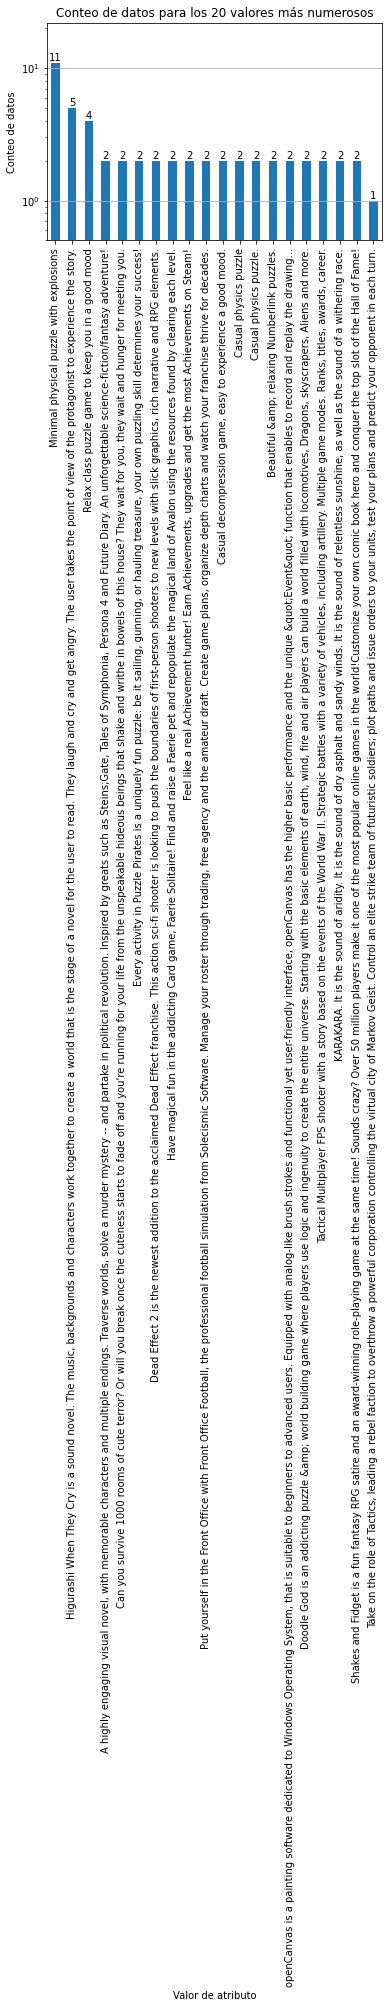

In [ ]:
execute_univariate_analysis(attribute_name="short_description",
                            analysis_mode="categorical")

> El atributo `short_description` contiene una descripción breve del videojuego según quién lo publique. Esta categoría es altamente informativa, ya que determina en cierta medida si el videojuego es de interés del jugador o no, lo cual puede inducir una compra y las expectativas del mismo.

> Si bien existen videojuegos con discripciones duplicadas, esto no es relevante a efectos del análisis, ya que es una situación plausible.

> La dificultad de este atributo radica en que para extraer información del mismo se deben aplicar técnicas de NLP, las cuáles se detallarán las secciones posteriores.

Análisis de atributo `estimated_sells`

Análisis del atributo 'estimated_sells'
Tipo de atributo: 'int64'

Cantidad de datos nulos: 0
Cantidad de datos duplcados: 3002


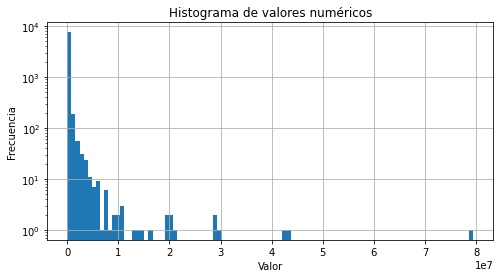

In [ ]:
execute_univariate_analysis(attribute_name="estimated_sells",
                            analysis_mode="float")

**Este atributo corresponde al *target* del problema de regresión**.

> Se puede ver que sigue una distribución que asemeja a una exponencial, concentrando sus valores fuertemente en ordenes de magnitud bajos, en general contiene ciertos *outliers*, pero aparenta ser una distribución que puediera explicarse a partir de los demás atributos del *dataset*. 

#### Análisis del atributo `rating`

Análisis del atributo 'rating'
Tipo de atributo: 'category'

Cantidad de datos nulos: 0
Cantidad de categorías totales: 5

Categorías presentes:
['Mixed', 'Positive', 'Mostly Positive', 'Very Positive', 'Negative']
Categories (5, object): ['Negative' < 'Mixed' < 'Mostly Positive' < 'Positive' < 'Very Positive']


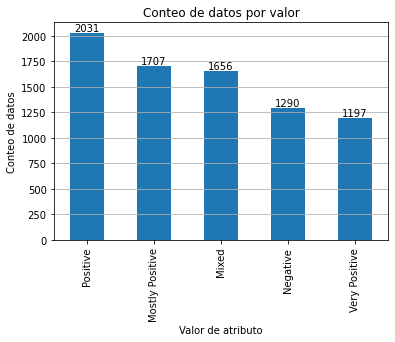

In [ ]:
execute_univariate_analysis(attribute_name="rating",
                            analysis_mode="categorical")

**Este atributo corresponde al *target* del problema de clasificación**.

> Se puede ver que las clases están bastante balanceadas y por lo tanto bien representadas, esto implica que no será necesario ejecutar mecanismos de compensación de desbalance, y que si los demás atributos son estadísticamente dependientes (tal como se tiene de hipótesis), entonces no debería haber problemas a la hora de generar un modelo. de clasificación.

### Conclusiones del EDA uni-variado

Para el *dataset* entregado no existe problema de existencia de datos duplicados ni de valores nulos en ninguna de las entradas del mismo, por lo cual no es necesario hacer imputación de datos, ni descartar atributos por lo mismo.

Las transformaciones a aplicar a cada atributo son las reportadas en el análisis de los mismos.

### Análisis Multivariado
En el análisis multivariado se analiza la interacción entre los atributos del dataset.

En primer lugar se evalua la relación entre atributos numéricos mediante una matriz de correlación y gráficamente mediante scatterplots

In [ ]:
#Matriz de correlacion entre atributos numericos
correlations = df_data.corr()
correlations.style.background_gradient(cmap='Blues')

,english,required_age,achievements,average_playtime,price,estimated_sells
english,1.000000,0.015799,0.009748,-0.007678,0.018056,0.014292
required_age,0.015799,1.000000,-0.001500,0.026692,0.157875,0.110789
achievements,0.009748,-0.001500,1.000000,0.000825,-0.026374,0.022180
average_playtime,-0.007678,0.026692,0.000825,1.000000,0.045651,0.161612
price,0.018056,0.157875,-0.026374,0.045651,1.000000,0.062935
estimated_sells,0.014292,0.110789,0.022180,0.161612,0.062935,1.000000


array([[<AxesSubplot:xlabel='achievements', ylabel='achievements'>,
        <AxesSubplot:xlabel='average_playtime', ylabel='achievements'>,
        <AxesSubplot:xlabel='price', ylabel='achievements'>,
        <AxesSubplot:xlabel='estimated_sells', ylabel='achievements'>],
       [<AxesSubplot:xlabel='achievements', ylabel='average_playtime'>,
        <AxesSubplot:xlabel='average_playtime', ylabel='average_playtime'>,
        <AxesSubplot:xlabel='price', ylabel='average_playtime'>,
        <AxesSubplot:xlabel='estimated_sells', ylabel='average_playtime'>],
       [<AxesSubplot:xlabel='achievements', ylabel='price'>,
        <AxesSubplot:xlabel='average_playtime', ylabel='price'>,
        <AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='estimated_sells', ylabel='price'>],
       [<AxesSubplot:xlabel='achievements', ylabel='estimated_sells'>,
        <AxesSubplot:xlabel='average_playtime', ylabel='estimated_sells'>,
        <AxesSubplot:xlabel='price', ylabel='es

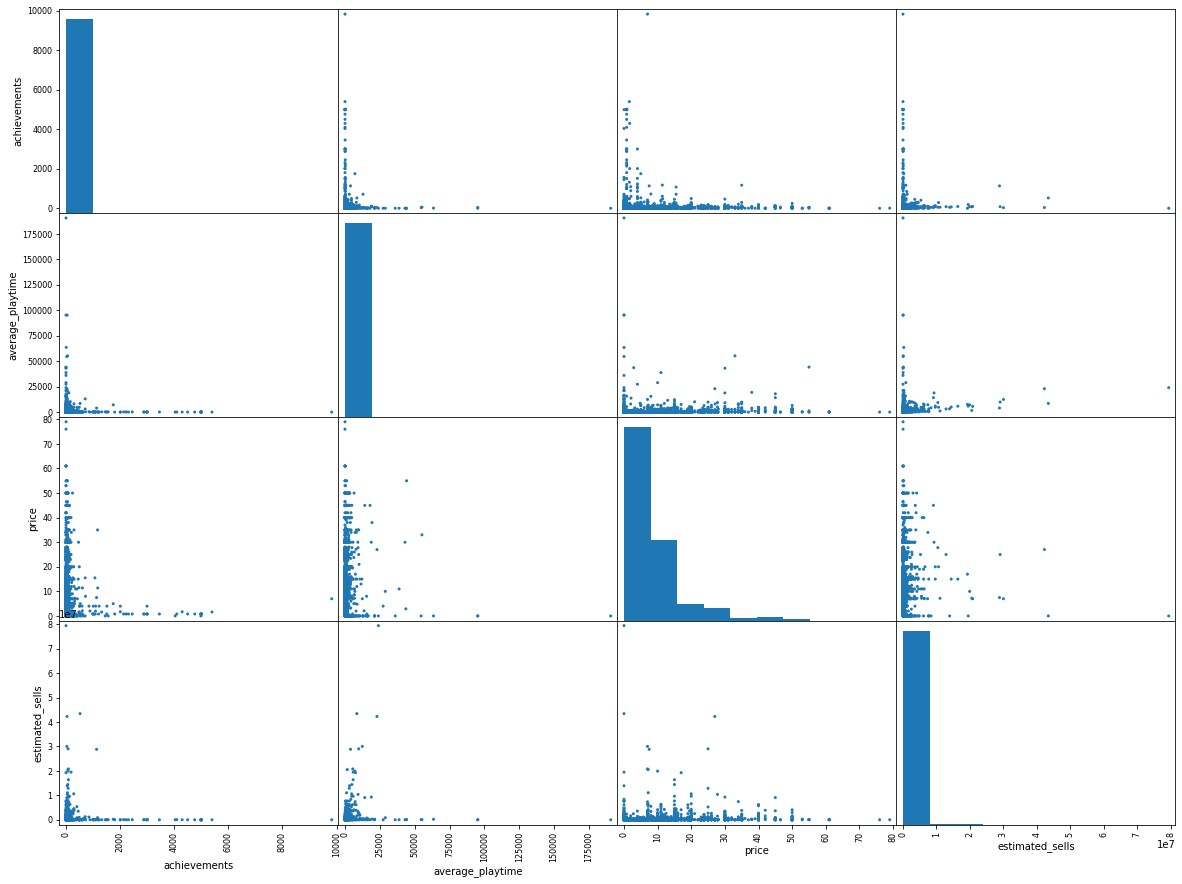

In [ ]:
pd.plotting.scatter_matrix(df_data[['achievements','average_playtime','price','estimated_sells']], alpha=1, figsize= (20,15), grid=True)

En base a la matriz de correlación y a la matriz de scatterplots se puede ver que estos atributos no están significativamente correlacionados unos con otros.
Numéricamente la correlación más grande se da entre `price`y `required_age` con un $15.8\%$.

Y gráficamente se ve que ninguna variación de estos atributos está directa o inversamente relacionado con la variación de otro atributo o con `estimated_sells` que es el target.

De esto se concluye que a priori ninguno de los artibutos numéricos por sí solo es fundamental en la predicción de las ventas estimadas

En base a las relaciones encontradas anteriormente se evalúa la relación entre `price` y `required_age`

In [ ]:
#Variacion del precio segun edad minima para jugar
fig = px.box(df_data, y='price', color='required_age')
fig.show()

Considerando principalmente las categorías de edad 0+, 16+ y 18+ que son aquellas que cuentan con más muestras en la columna `required_age` se puede ver que a medida que aumenta la edad requerida para jugar aumenta el precio del videojuego.
Sin embargo esta tendencia no se cumple para todas las categorías.

In [ ]:
#Variacion de las ventas estimadas segun edad minima para jugar
fig = px.box(df_data, y='estimated_sells', color='required_age', log_y= True)
fig.show()

Las ventas estimadas están en un orden de magintud mucho más grande que las edades requeridas, es por esto que para poder observar una tendencia se usa escala logarítmica. Al igual que en el gráfico anterior considerando las edades que presentan más muestras en el dataset las ventas estimadas aumentan conforme aumenta la edad requrida para jugar, y nuevamente la tendencia no se cumple para todas las categorías.

In [ ]:
#Variacion de las ventas estimadas segun fecha de lanzamiento del juego
px.scatter(df_data, x= df_data['release_date'], y = df_data['estimated_sells'], log_y = True)

Se puede ver que la mayoria de las ventas estimadas corresponden a juegos más actuales. No se observan anomalías temporales (Se podría ver efecto de inflación, recesión, etc). Solo una tendencia relacionada con la mayor cantidad de muestras en los últimos años, lo que no significa que estos se vendan más

In [ ]:
#Variacion de las ventas estimadas segun fecha de lanzamiento del juego logros del juego
px.scatter(df_data, x= df_data['achievements'], y = df_data['estimated_sells'], log_x = True, log_y = True)

Al parecer hay una cantidad óptima de logros que es preferido por los jugadores. Esto hace sentido, ya que un juego con pocos logros, puede resultar poco desafiante, y un juego con demasiados logros en su historia puede provocar que el jugador se aburra de no acercarse al final. Ambas razones pueden desmotivar al jugador al comprar este juego.
En conclusión, un juegono necesariamente tendrá mayores ventas por tener más logros, se ve una tendencia de los jugadores a acumularse en un rango.

## Preparación de datos

En esta sección se definen las funciones que permiten hacer la preparación de los datos según fue descrito en la sección anterior de EDA para los distintos atributos presentes en el *dataset*.

Se comienza definiendo la función que procesará el atributo *datetime*, esta extrae el mes y el día contenido en la fecha y crea los atributos `sin_day`, `cos_day`, `sin_month` y `cos_month` a modo de capturar la naturaleza *circular* de los elementos *día* y *noche*.

In [ ]:
def get_datetime_features(s: PandasSeries) -> PandasDF:
    """
    Given a Pandas Series that contains datetimes, it creates a DataFrame which
    contains the columns (sin_day, cos_day, sin_month, cos_month) that are the
    sine and cosine functions applied over the day and month values of the
    original series

    Parameters
    ----------
    s
        Pandas datetime series to process
    
    Returns
    --------
    The dataframe with the stated columns
    """
    series_name: str = s.name
    series_properties: DatetimeProperties = s.astype(dtype="datetime64").dt
    
    norm_day_series: PandasSeries = 2*np.pi*series_properties.day/31
    norm_month_series: PandasSeries = 2*np.pi*series_properties.month/12
    
    sin_day_series: PandasSeries = np.sin(
        norm_day_series
    ).rename(f"{series_name}_sin_day")
    cos_day_series: PandasSeries = np.cos(
        norm_day_series
    ).rename(f"{series_name}_cos_day")
    sin_month_series: PandasSeries = np.sin(
        norm_month_series
    ).rename(f"{series_name}_sin_month")
    cos_month_series: PandasSeries = np.cos(
        norm_month_series
    ).rename(f"{series_name}_cos_month")

    return pd.concat(
        [sin_day_series, cos_day_series, sin_month_series, cos_month_series],
        axis=1
    )

Luego, la transformación definida se prueba con su atributo correspondiente.

In [ ]:
get_datetime_features(s=df_data["release_date"])

,release_date_sin_day,release_date_cos_day,release_date_sin_month,release_date_cos_month
0,-0.394356,0.918958,1.000000e+00,6.123234e-17
1,0.937752,0.347305,1.224647e-16,-1.000000e+00
2,0.937752,0.347305,-8.660254e-01,-5.000000e-01
3,0.724793,0.688967,-8.660254e-01,5.000000e-01
4,0.988468,0.151428,1.000000e+00,6.123234e-17
...,...,...,...,...
7876,-0.848644,0.528964,1.000000e+00,6.123234e-17
7877,-0.937752,0.347305,-5.000000e-01,-8.660254e-01
7878,-0.998717,-0.050649,1.000000e+00,6.123234e-17
7879,-0.571268,0.820763,-5.000000e-01,8.660254e-01


Posteriormente, se define el extractor de características multicategóricas que había sido detallado previamente en la sección de EDA.

In [ ]:
def binary_cat_disbalance(s: PandasSeries) -> float:
    """
    Computes disbalance for a binary categorical series

    Parameters
    ----------
    s
        Pandas series that contains the boolean data
    
    Returns
    -------
    The proportion of the data that belongs to the most numerous category
    """
    true_count: int = sum(s)
    total_count: int = len(s)
    return max(true_count, total_count-true_count)/total_count

In [ ]:
def get_multicategorical_features(s: PandasSeries,
                                  category_list: List[str]) -> PandasDF:
    """
    Given a Pandas Series that contains multicategorical values, it creates a
    DataFrame which contains a set of columns that corresponds to the
    disgregated categories contained across all the series; the values of these
    columns are True if the corresponding category was a part of the category
    list of the corresponding item, or False if not. The created columns are
    the ones contained in category_list

    Parameters
    ----------
    s
        Pandas multicategorical series to process
    category_list
        List of categories considered for the feature creation
    
    Returns
    -------
    The dataframe with the stated columns
    """
    df_series_list: List[PandasSeries] = list()
    # cls stands for "Category List Series"
    cls: PandasSeries = s.apply(lambda x: x.split(';'))
    cat: str
    for cat in category_list:
        df_series_list.append(cls.apply(lambda x: cat in x).rename(
            f"{s.name}_{cat.replace(' ', '_')}"
        ))
    if len(df_series_list) == 0:
        return pd.DataFrame(index=range(len(s)))
    else:
        return pd.concat(df_series_list, axis=1)

Con la transfomación definida, se prueba la misma utilizando alguno de los atribuos multicategóricos.

In [ ]:
get_multicategorical_features(s=df_data["genres"], category_list=[
    'Adventure', 'Casual', 'Free to Play', 'Indie', 'Simulation', 'Strategy',
    'Sports', 'RPG', 'Action', 'Violent', 'Gore', 'Early Access', 'Racing',
    'Massively Multiplayer', 'Animation & Modeling', 'Design & Illustration'
])

,genres_Adventure,genres_Casual,genres_Free_to_Play,genres_Indie,genres_Simulation,genres_Strategy,genres_Sports,genres_RPG,genres_Action,genres_Violent,genres_Gore,genres_Early_Access,genres_Racing,genres_Massively_Multiplayer,genres_Animation_&_Modeling,genres_Design_&_Illustration
0,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False
2,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
4,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7876,True,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False
7877,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
7878,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
7879,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False


La siguiente transformación a definir corresponde a la generación de *embeddings* a partir de atributos que contengan lenguaje natural.

In [ ]:
def get_nlp_embeddings(s: PandasSeries) -> PandasDF:
    """
    Given a Pandas Series that contains natural language sentences, it creates
    a DataFrame which contains as columns the sentence embedding coordinates

    Parameters
    ----------
    s
        Pandas series that contains the natural language sentences
    
    Returns
    -------
    The described DataFrame
    """
    embeddings: np.ndarray = embedding_model.encode(sentences=s)
    return pd.DataFrame(
        data=embeddings,
        columns=[f"{s.name}_emb_{i}" for i in range(embeddings.shape[1])]
    )

Con la transformación definida, se procede a probar la misma con el único atributo con lenguaje natural que se mantiene del *dataset*.

In [ ]:
get_nlp_embeddings(s=df_data["short_description"][:1000])

,short_description_emb_0,short_description_emb_1,short_description_emb_2,short_description_emb_3,short_description_emb_4,short_description_emb_5,short_description_emb_6,short_description_emb_7,short_description_emb_8,short_description_emb_9,...,short_description_emb_374,short_description_emb_375,short_description_emb_376,short_description_emb_377,short_description_emb_378,short_description_emb_379,short_description_emb_380,short_description_emb_381,short_description_emb_382,short_description_emb_383
0,0.070651,-0.033478,0.023642,-0.015325,0.098421,0.039806,0.014792,-0.018739,-0.011563,-0.010853,...,0.112124,-0.018269,-0.061614,0.045388,-0.070668,0.016374,0.046618,0.121576,-0.114362,0.022753
1,0.014818,0.000905,-0.001278,-0.032858,-0.057761,0.031188,0.028899,-0.096138,-0.092940,-0.025997,...,0.050960,0.012403,0.035739,-0.010404,0.001548,0.019444,0.044347,-0.134416,-0.077961,0.026888
2,0.015158,0.082296,0.043008,0.011211,-0.002957,-0.058133,0.010903,0.009291,0.058639,0.026887,...,0.064826,-0.122164,0.008803,0.062598,0.021457,0.068262,0.128991,-0.007557,0.050375,-0.024397
3,-0.079285,-0.004833,-0.048010,-0.002476,0.035829,0.006250,-0.106368,-0.104099,-0.036408,0.011419,...,0.087886,0.001139,0.047832,0.094009,0.005601,0.036980,0.048832,-0.007528,-0.058042,0.017037
4,-0.044677,-0.014297,-0.000329,-0.122945,-0.059628,-0.030114,0.046060,0.022917,-0.043207,-0.020775,...,0.009902,0.059015,-0.009411,-0.116897,0.024895,0.006828,0.056121,-0.116220,-0.026254,0.034127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.055395,0.034429,-0.044701,0.004279,-0.097794,0.003122,0.010050,-0.038432,-0.015621,-0.040379,...,-0.013725,0.016757,0.071466,0.000466,0.044830,-0.022711,0.049742,-0.032208,-0.015138,0.016529
996,-0.041582,0.044352,-0.032847,-0.058997,-0.068036,0.013629,0.029143,0.003077,0.022475,0.064175,...,-0.030872,0.097616,0.023705,0.046793,-0.062802,0.018314,0.035341,-0.065673,0.005189,0.102320
997,-0.017956,0.097644,-0.043367,0.023253,0.030364,0.033075,-0.014852,-0.021574,0.005137,-0.004356,...,0.089086,0.045580,-0.029548,0.050435,-0.069244,0.045800,0.096459,0.034074,-0.034344,-0.037116
998,0.057522,-0.003662,-0.022735,-0.095193,-0.043004,0.073505,-0.058092,-0.019664,-0.006509,0.184689,...,0.081101,-0.079953,-0.026335,0.136323,0.104156,-0.019999,-0.000131,0.012805,-0.081462,0.004068


Con las tranformaciones relevantes definidas, se procede a definir una clase *transformer* que permita extraer todas estas características relevantes. Notar que es necesario una etapa de *fit* y de *transform* dado que en esta primera etapa se identifican los atributos categoricos binarios que se utilizarán y además se identifican las categorías a extraer de los atributos multicategoría.

In [ ]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Feature extractor class, this feature extractor extracts the
    multicategorical features, filters the categorical features based on class
    disbalance, and if the model required to, extracts the datetime features

    The class attributes are defined according to the values of the constructor
    parameters, refer to the constructor for more information

    Attributes
    ----------
    model_obj
        Refer to 'model_objective' parameter of the constructor
    use_nlp
        Refer to 'use_nlp_embeddings' parameter of the constructor
    disbalance_th
        Refer to 'model_objective' parameter of the constructor
    bca
        Refer to 'binary_categorical_attributes' parameter of the constructor
    mca
        Refer to 'multicategorical_attributes' parameter of the constuctor
    dta
        Refer to 'datetime_attributes' parameter of the constrcutor
    nlp
        Refer to 'nlp_attributes' parameter of the constructor
    pst
        Refer to 'passtrough_attributes' parameter of the constructor
    balanced_bca
        List of balanced binary categories. Is None if 'fit' was not performed
    balanced_mca
        Dictionary that contains as keys the multicategoritcal attribute names,
        and as keys, the list of disgregated categories that are balanced. Is
        None if 'fit' was not performed
    """
    def __init__(self, binary_categorical_attributes: List[str],
                 multicategorical_attributes: List[str],
                 disbalance_threshold: float, model_objective: str,
                 use_nlp_embeddings: bool,
                 datetime_attributes: Optional[List[str]] = None,
                 nlp_attributes: Optional[List[str]] = None,
                 passthrough_attributes: Optional[List[str]] = None):
        """
        Class constructor, sets all its parameters as attributes, and checks if
        the parameter values are coherent

        Parameters
        ----------
        binary_categorical_attributes
            List of binary categorical attribute names
        datetime_attributes
            List of attribute names which are datetime-valued
        multicategorical_attributes
            List of multicategorical attribute names
        disbalance_threshold
            Disbalance threshold for the binary categories
        model_objective
            Model objective, the only ones available are "classification" and
            "regression"
        use_nlp_embeddings
            Boolean flag that defines if NLP embeddings will be used over the
            NL attributes or not
        nlp_attributes
            List of attibutes that contain natural language
        passthrough_attributes
            List of attributes to be passed through
        
        Raises
        ------
        ValueError
            If the stated model_objective is neither "classification" nor
            "regression", if the usage of NLP embeddings is requested and the
            NLP attribute list is None, and if the model objective is
            "regression" and the datetime atribute list is None
        """
        self = self
        self.binary_categorical_attributes: List[str] = \
            binary_categorical_attributes
        self.multicategorical_attributes: List[str] = \
            multicategorical_attributes
        self.datetime_attributes: Optional[List[str]] = datetime_attributes
        self.nlp_attributes: Optional[List[str]] = nlp_attributes
        self.passthrough_attributes: Optional[List[str]] = \
            passthrough_attributes
        
        self.model_objective: str = model_objective
        self.use_nlp_embeddings: bool = use_nlp_embeddings
        self.disbalance_threshold: float = disbalance_threshold

        if not (self.model_objective == "classification"
                or self.model_objective == "regression"):
            raise ValueError("model_objective value must be 'classification' "
                             "or 'regression'")
        if (self.model_objective == "regression"
            and self.datetime_attributes is None):
            raise ValueError("If model_objective is 'regression', the value "
                             "of datetime_attributes must not be None")
        if self.use_nlp_embeddings and self.nlp_attributes is None:
            raise ValueError("If use_nlp_embeddings is True, the value of "
                             "nlp_attributes must not be None")

        self.balanced_bca: Optional[List[str]] = None
        self.balanced_mca: Optional[Dict[str, List[str]]] = None

    def fit(self, X: ArrayLike, y: Optional[ArrayLike] = None):
        X_: PandasDF = X.reset_index()
        self.balanced_bca = list()
        cat: str
        cat_series: PandasSeries
        for cat in self.binary_categorical_attributes:
            cat_series = X_[cat].astype(bool)
            if (binary_cat_disbalance(s=cat_series) <=
                self.disbalance_threshold):
                self.balanced_bca.append(cat_series.name)
        self.balanced_mca = dict()
        multicat: str
        for multicat in self.multicategorical_attributes:
            multicat_balanced_list: List[str] = list()
            multicat_series: PandasSeries = X_[multicat]
            total_multicat_list: List[str] = multicat_series.apply(
                lambda x: x.split(';')
            ).explode().unique()
            total_features: PandasDF = get_multicategorical_features(
                s=multicat_series, category_list=total_multicat_list
            )
            for cat in total_multicat_list:
                if binary_cat_disbalance(
                    s=total_features[f"{multicat}_{cat.replace(' ', '_')}"]
                ) <= self.disbalance_threshold:
                    multicat_balanced_list.append(cat)
            self.balanced_mca[multicat] = multicat_balanced_list
        return self

    def transform(self, X: ArrayLike, y: Optional[ArrayLike] = None):
        X_: PandasDF = X.reset_index()
        concat_elements: List[Union[PandasSeries, PandasDF]] = list()
        cat: str
        for cat in self.balanced_bca:
            concat_elements.append(X_[cat].astype(bool))
        if self.model_objective == "regression":
            for cat in self.datetime_attributes:
                concat_elements.append(get_datetime_features(s=X_[cat]))
        subcat_list: List[str]
        for cat, subcat_list in self.balanced_mca.items():
            concat_elements.append(get_multicategorical_features(
                s=X_[cat], category_list=subcat_list)
            )
        if self.use_nlp_embeddings:
            for cat in self.nlp_attributes:
                concat_elements.append(get_nlp_embeddings(s=X_[cat]))
        for cat in self.passthrough_attributes:
            concat_elements.append(X_[cat])
        if len(concat_elements) == 0:
            return pd.DataFrame(index=range(len(X_)))
        else:
            return pd.concat(concat_elements, axis=1)

Con la clase de extracción de características definida, se procede a probar la misma sobre el *dataset* de videojuegos.

In [ ]:
bin_attributes: List[str] = ["english"]
dt_attributes: List[str] = ["release_date"]
multicat_attributes: List[str] = ["developer", "publisher", "platforms",
                                  "categories", "genres", "tags"]
nl_attributes: List[str] = ["short_description"]
num_attributes: List[str] = ["achievements", "average_playtime", "price"]

In [ ]:
example_feature_extractor: FeatureExtractor = FeatureExtractor(
    binary_categorical_attributes=bin_attributes,
    multicategorical_attributes=multicat_attributes, disbalance_threshold=0.9,
    model_objective="regression", use_nlp_embeddings=True,
    datetime_attributes=dt_attributes, nlp_attributes=nl_attributes,
    passthrough_attributes=num_attributes
)

In [ ]:
example_features: PandasDF = example_feature_extractor.fit_transform(
    X=df_data[:100]
)

In [ ]:
example_test_features: PandasDF = example_feature_extractor.transform(
    X=df_test[:100]
)

In [ ]:
example_test_features.head()

,release_date_sin_day,release_date_cos_day,release_date_sin_month,release_date_cos_month,platforms_mac,platforms_linux,categories_Steam_Achievements,categories_Steam_Trading_Cards,categories_Steam_Cloud,categories_Stats,...,short_description_emb_377,short_description_emb_378,short_description_emb_379,short_description_emb_380,short_description_emb_381,short_description_emb_382,short_description_emb_383,achievements,average_playtime,price
0,0.937752,0.347305,-0.866025,0.500000,False,False,False,False,False,False,...,0.033111,-0.026343,0.088913,0.071914,-0.030100,-0.028138,-0.041032,0,239,4.99
1,0.848644,0.528964,-0.500000,0.866025,True,False,False,False,False,False,...,0.082405,0.008499,0.007726,0.024494,0.015774,0.034733,0.061705,0,0,3.99
2,0.394356,0.918958,-0.866025,0.500000,False,False,False,False,False,False,...,-0.028816,-0.061788,0.055384,0.075511,-0.021022,-0.007473,-0.017780,28,0,24.99
3,0.988468,0.151428,0.500000,0.866025,False,False,False,True,False,True,...,0.058319,0.089212,-0.009925,-0.001050,-0.086491,-0.031013,0.037973,0,206,0.79
4,-0.998717,-0.050649,0.500000,0.866025,True,True,False,False,False,False,...,0.085472,-0.027556,0.096234,0.062636,-0.007720,-0.104878,0.028732,8,272,10.99


In [ ]:
example_test_features.columns

Index(['release_date_sin_day', 'release_date_cos_day',
       'release_date_sin_month', 'release_date_cos_month', 'platforms_mac',
       'platforms_linux', 'categories_Steam_Achievements',
       'categories_Steam_Trading_Cards', 'categories_Steam_Cloud',
       'categories_Stats',
       ...
       'short_description_emb_377', 'short_description_emb_378',
       'short_description_emb_379', 'short_description_emb_380',
       'short_description_emb_381', 'short_description_emb_382',
       'short_description_emb_383', 'achievements', 'average_playtime',
       'price'],
      dtype='object', length=418)

Con la principal clase de extracción de características definida, se procede a definir la función que genere los *pipelines* necesarios de los datos para poder utilizar los clasificadores requeridos.

In [ ]:
def gen_pipeline(disbalance_threshold: float, model_objective: str,
                 use_nlp_embeddings: bool,
                 model: Optional[Any] = None) -> Pipeline:
    """
    Generates and returns a pipeline with the stated properties

    Parameters
    ----------
    disbalance_threshold
        Desbalance Threshold for the binary categorical variables
    model_objective
        Model objective for this pipeline, can be only "classification" or
        "regression"
    use_nlp_embeddings
        Boolean flag that defines if the NLP embeddings will be used or not
    model
        Optional parameter, that sets the model to be used after the
        preprocessing if it is not None; if it is None, no model will be used,
        and the pipeline transform will return only the features dataset
    
    Returns
    -------
    The generated pipeline
    """
    pipe_steps: List[Tuple[str, Any]] = [
        ("feature_extraction", FeatureExtractor(
            binary_categorical_attributes=bin_attributes,
            multicategorical_attributes=multicat_attributes,
            disbalance_threshold=disbalance_threshold,
            model_objective=model_objective,
            use_nlp_embeddings=use_nlp_embeddings,
            datetime_attributes=dt_attributes, nlp_attributes=nl_attributes,
            passthrough_attributes=num_attributes
        )),
        ("numerical_scaling", RobustScaler()),
        ("model", model)
    ]
    #if model is not None:
     #   pipe_steps.append(("model", model))
    return Pipeline(steps=pipe_steps)

In [ ]:
example_pipe: Pipeline = gen_pipeline(disbalance_threshold=0.9,
                                      model_objective="regression",
                                      use_nlp_embeddings=True)

In [ ]:
example_pipe.fit(X=df_data[:100])
print("Pipeline successfully fitted")

Pipeline successfully fitted


In [ ]:
example_output: np.ndarray = example_pipe.transform(X=df_data.iloc[100:200])

In [ ]:
print(f"Shape de la salida: {example_output.shape}")
print("Característica de uno de los datos en particular")
print(np.round_(example_output[2], decimals=2))

Shape de la salida: (100, 418)
Característica de uno de los datos en particular
[-0.66  0.17 -0.58  0.87  1.    1.   -1.    0.   -1.    0.    1.    0.
  0.    0.    0.    0.    0.    0.    1.   -1.    0.    1.    1.    0.
  1.    0.    0.    0.    1.    0.    0.   -0.05  0.64 -0.19  0.52  0.91
  0.27  0.1  -1.34  1.26  0.37 -0.19 -1.8   0.12 -0.4  -0.26  0.46 -0.93
 -0.26 -0.93 -0.38  1.68  1.11  0.68 -0.2   0.52 -2.43 -0.41 -0.13  1.41
 -0.3   0.33 -0.24 -1.01  0.7  -0.09  0.77 -0.4  -0.77 -1.26  0.88  0.96
  0.58 -0.18 -1.97 -0.11 -0.58 -0.78 -1.28  1.29  0.3  -0.02 -0.48 -0.21
  0.14 -0.54 -0.02 -1.32 -1.42  0.27 -0.12  0.78 -0.17  0.72 -0.   -0.1
  0.36  1.05  0.35 -0.14 -0.56 -0.78 -0.7  -0.29 -0.52 -0.5  -1.27  0.05
 -0.66 -2.13 -0.38  0.75  1.29  1.32 -0.18  1.02  0.3  -0.16  0.42  0.01
 -0.52  0.82 -0.62 -0.91 -0.06  0.27 -0.78  0.42  0.21 -0.23  0.48 -0.55
  1.01 -0.08 -0.22 -1.23  0.45 -0.72  0.75 -0.83  0.12 -0.2   0.14 -0.22
  0.29 -0.02 -0.2  -0.66 -0.83  0.28  1.08 -0.2  

En esta salida, se puede ver que los primeros cuatro valores corresponden a las transformaciones sinusoidales de los atributos de fecha, mientras que sigue los valores binarios de los atributos categóricos binarios y las categorías disgregadas de los atributos multicategóricos, finalizando con el embedding del texto natural.

Teniendo bien definida la extracción de características, se procede a realizar el *holdout* de los datos. Para esto hay que entender que el *dataset* fue provisto de un subconjunto con *target* y un subconjunto sin *target*, este último corresponde a los datos con los cuales se participará en la competencia y por ende son los de *test*. El *holdout* se realiza sobre los datos con *target* para generar conjuntos de **entrenamiento** (*train*) y **validación** (*validation*).

In [ ]:
clf_target: str = "rating"
reg_target: str = "estimated_sells"
attributes: List[str] = (
    bin_attributes + dt_attributes + multicat_attributes
    + nl_attributes + num_attributes
)

X_train: PandasDF
X_val: PandasDF
Y_train: PandasDF
Y_val: PandasDF
X_train, X_val, Y_train, Y_val = train_test_split(
    df_data[attributes], df_data[[clf_target, reg_target]], test_size=0.3,
    stratify=df_data[clf_target], random_state=1234
)

y_clf_train: PandasSeries = Y_train[clf_target]
y_reg_train: PandasSeries = Y_train[reg_target]
y_clf_val: PandasSeries = Y_val[clf_target]
y_reg_val: PandasSeries = Y_val[reg_target]

## Baseline

Con las funcionalidades de preprocesamiento bien defindas en el *dataset*, se procede a realizar un *baseline* para cada problema utilizando un modelo *dummy*.

In [ ]:
dummy_clf_pipe: Pipeline = gen_pipeline(
    disbalance_threshold=0.99, model_objective="classification",
    use_nlp_embeddings=True, model=DummyClassifier()
)
dummy_reg_pipe: Pipeline = gen_pipeline(
    disbalance_threshold=0.99, model_objective="regression",
    use_nlp_embeddings=True, model=DummyRegressor()
)

Entrenamiento de los modelos de *baseline*.

In [ ]:
dummy_clf = dummy_clf_pipe.fit(X=X_train, y=y_clf_train)

In [ ]:
dummy_reg = dummy_reg_pipe.fit(X=X_train, y=y_reg_train)

Ejecución de las predicciones de los modelos de *baseline*.

In [ ]:
y_dummy_clf_pred = dummy_clf_pipe.predict(X_val)

In [ ]:
y_dummy_reg_pred = dummy_reg_pipe.predict(X_val)

Evaluación de los modelos de *baseline*.

In [ ]:
print(classification_report(y_true=y_clf_val, y_pred=y_dummy_clf_pred))

                 precision    recall  f1-score   support

          Mixed       0.00      0.00      0.00       497
Mostly Positive       0.00      0.00      0.00       512
       Negative       0.00      0.00      0.00       387
       Positive       0.26      1.00      0.41       610
  Very Positive       0.00      0.00      0.00       359

       accuracy                           0.26      2365
      macro avg       0.05      0.20      0.08      2365
   weighted avg       0.07      0.26      0.11      2365



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
r2_score(y_true=y_reg_val, y_pred=y_dummy_reg_pred)

-3.161769599824282e-05

In [ ]:
np.sqrt(mean_squared_error(y_true=y_reg_val, y_pred=y_dummy_reg_pred))

1976758.9734582796

---

## Optimización de los Modelos

Para seleccionar aquellos atributos que más influyen en la predicción se prueban combinaciones de diferentes parámetros para mejorar el modelo de clasificación:

In [ ]:
#Parametros comunes al regresor y clasificador
common_parameters = {
    "feature_extraction__binary_categorical_attributes": [bin_attributes],
    "feature_extraction__multicategorical_attributes": [multicat_attributes],
    "feature_extraction__disbalance_threshold": [0.7, 0.99, 0.9999],
    "feature_extraction__use_nlp_embeddings": [True, False],
    "feature_extraction__datetime_attributes": [dt_attributes], 
    "feature_extraction__nlp_attributes": [nl_attributes],
    "feature_extraction__passthrough_attributes": [num_attributes],
    "numerical_scaling": [RobustScaler()]
}

In [ ]:
rf_parameters: Dict[str, Any] = {
    "model": [RandomForestClassifier()],
    "model__n_estimators": [50, 70, 80],
    "model__criterion": ["gini", "entropy"]
}

knn_parameters: Dict[str, Any] = {
    "model": [KNeighborsClassifier()], 
    "model__n_neighbors": [3, 5, 7]
}
mlpcl_parameters: Dict[str, Any] = {
    "model": [MLPClassifier()],
    "model__early_stopping": [True],
    "model__hidden_layer_sizes": [(400, 200, 100), (600,300,100)],
    "model__learning_rate_init": [1e-06], 
    "model__max_iter": [10000],
    "model__n_iter_no_change": [1000]
}
parameter_grid: List[Dict[str, Any]] = [
    {**common_parameters, **rf_parameters},
  #  {**common_parameters, **knn_parameters},
  #  {**common_parameters, **mlpcl_parameters}
]

hsv_clf: HalvingGridSearchCV = HalvingGridSearchCV(estimator=dummy_clf_pipe, 
                                    param_grid=parameter_grid, cv=3,verbose=10,
                                    scoring = 'f1_weighted'
)

In [ ]:
hsv_clf.fit(X_train, y=y_clf_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 204
max_resources_: 5516
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 204
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START feature_extraction__binary_categorical_attributes=['english'], feature_extraction__datetime_attributes=['release_date'], feature_extraction__disbalance_threshold=0.7, feature_extraction__multicategorical_attributes=['developer', 'publisher', 'platforms', 'categories', 'genres', 'tags'], feature_extraction__nlp_attributes=['short_description'], feature_extraction__passthrough_attributes=['achievements', 'average_playtime', 'price'], feature_extraction__use_nlp_embeddings=True, model=RandomForestClassifier(), model__criterion=gini, model__n_estimators=50, numerical_scaling=RobustScaler()
[CV 1/3; 1/36] END feature_extraction__binary_categorical_attributes=['english'], feature_extraction__datetime_attributes=['

HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('feature_extraction',
                                               FeatureExtractor(binary_categorical_attributes=['english'],
                                                                datetime_attributes=['release_date'],
                                                                disbalance_threshold=0.99,
                                                                model_objective='classification',
                                                                multicategorical_attributes=['developer',
                                                                                             'publisher',
                                                                                             'platforms',
                                                                                             'categories',
                                                                                  

In [ ]:
# Se visualizan el mejor score y los parámetros del mejor pipeline encontrado
print('Mejor métrica promedio:', hsv_clf.best_score_)
print('Parámetros óptimos:    ', hsv_clf.best_params_)

Mejor métrica promedio: 0.31545400717902705
Parámetros óptimos:     {'feature_extraction__binary_categorical_attributes': ['english'], 'feature_extraction__datetime_attributes': ['release_date'], 'feature_extraction__disbalance_threshold': 0.99, 'feature_extraction__multicategorical_attributes': ['developer', 'publisher', 'platforms', 'categories', 'genres', 'tags'], 'feature_extraction__nlp_attributes': ['short_description'], 'feature_extraction__passthrough_attributes': ['achievements', 'average_playtime', 'price'], 'feature_extraction__use_nlp_embeddings': False, 'model': RandomForestClassifier(criterion='entropy', n_estimators=80), 'model__criterion': 'entropy', 'model__n_estimators': 80, 'numerical_scaling': RobustScaler()}


In [ ]:
def optimCLF():
    #Optim pipeline
    clf_pipe: Pipeline = gen_pipeline(
    disbalance_threshold=0.99, model_objective="classification",
        use_nlp_embeddings=False, 
        model=RandomForestClassifier(criterion='entropy', n_estimators=80)
    )

    #Fit
    clf_pipe.fit(X_train, y=y_clf_train)

    #Predict
    y_clf_pred = clf_pipe.predict(X_val)

    #Metrics
    print(classification_report(y_true=y_clf_val, y_pred=y_clf_pred))
    return clf_pipe

optimCLF()

                 precision    recall  f1-score   support

          Mixed       0.32      0.31      0.32       497
Mostly Positive       0.26      0.24      0.25       512
       Negative       0.42      0.36      0.39       387
       Positive       0.32      0.43      0.37       610
  Very Positive       0.39      0.29      0.33       359

       accuracy                           0.33      2365
      macro avg       0.34      0.33      0.33      2365
   weighted avg       0.34      0.33      0.33      2365



Pipeline(steps=[('feature_extraction',
                 FeatureExtractor(binary_categorical_attributes=['english'],
                                  datetime_attributes=['release_date'],
                                  disbalance_threshold=0.99,
                                  model_objective='classification',
                                  multicategorical_attributes=['developer',
                                                               'publisher',
                                                               'platforms',
                                                               'categories',
                                                               'genres',
                                                               'tags'],
                                  nlp_attributes=['short_description'],
                                  passthrough_attributes=['achievements',
                                                          'average_playtime',
         

## Regresión

Análogo al caso del clasificador se crea un diccionario con 3 modelos disintos a probar en el *Grid Search* y luego se obtiene el mejor modelo

In [ ]:
lasso_parameters: Dict[str, Any] = {
    "model": [Lasso()],
    "model__alpha": [1.0, 5.0],
    "model__random_state": [1234]
}

en_parameters: Dict[str, Any] = {
    "model": [ElasticNet()], 
    "model__alpha": [1.0 , 5.0],
    "model__l1_ratio": [0.1, 0.5],
    "model__random_state": [1234]
}
mlp_parameters: Dict[str, Any] = {
    "model": [MLPRegressor()],
    "model__hidden_layer_sizes": [(400, 200, 100), (600,300,100)], 
    "model__learning_rate_init": [1e-1, 1e-2],
    "model__max_iter": [10_000], 
    "model__early_stopping": [True],
    "model__random_state": [1234]
}
parameter_grid: List[Dict[str, Any]] = [
    {**common_parameters, **lasso_parameters},
    {**common_parameters, **en_parameters},
    {**common_parameters, **mlp_parameters}
]

hsv_rg: HalvingGridSearchCV = HalvingGridSearchCV(estimator=dummy_reg_pipe, 
                                     param_grid=parameter_grid, cv=3,verbose=10, n_jobs=-1,
                                     scoring = 'r2'
)

In [ ]:
hsv_rg.fit(X=X_train, y=y_reg_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 204
max_resources_: 5516
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 204
Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 1
n_candidates: 20
n_resources: 612
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 7
n_resources: 1836
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 3
n_candidates: 3
n_resources: 5508
Fitting 3 folds for each of 3 candidates, totalling 9 fits


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('feature_extraction',
                                               FeatureExtractor(binary_categorical_attributes=['english'],
                                                                datetime_attributes=['release_date'],
                                                                disbalance_threshold=0.99,
                                                                model_objective='regression',
                                                                multicategorical_attributes=['developer',
                                                                                             'publisher',
                                                                                             'platforms',
                                                                                             'categories',
                                                                                      

In [ ]:
# Se visualizan el mejor score y los parámetros del mejor pipeline encontrado
print('Mejor métrica promedio:', hsv_rg.best_score_)
print('Parámetros óptimos:    ', hsv_rg.best_params_)

Mejor métrica promedio: 0.03753367437311972
Parámetros óptimos:     {'feature_extraction__binary_categorical_attributes': ['english'], 'feature_extraction__datetime_attributes': ['release_date'], 'feature_extraction__disbalance_threshold': 0.9999, 'feature_extraction__multicategorical_attributes': ['developer', 'publisher', 'platforms', 'categories', 'genres', 'tags'], 'feature_extraction__nlp_attributes': ['short_description'], 'feature_extraction__passthrough_attributes': ['achievements', 'average_playtime', 'price'], 'feature_extraction__use_nlp_embeddings': False, 'model': ElasticNet(random_state=1234), 'model__alpha': 1.0, 'model__l1_ratio': 0.5, 'model__random_state': 1234, 'numerical_scaling': RobustScaler()}


In [ ]:
#Este modelo deberia dar el mejor resultado segun el Grid Search
def optimRG():
    #Optim pipeline
    rgr_optim: Pipeline = gen_pipeline(
    disbalance_threshold=0.9999, model_objective='regression',
        use_nlp_embeddings=False, 
        model=ElasticNet(alpha=1.0,
                         l1_ratio = 0.5,
                         random_state=1234)
    )

    #Fit
    rgr_optim.fit(X_train, y=y_reg_train)

    #Predict
    y_rgr_pred = rgr_optim.predict(X_val)

    #Metrics
    print(r2_score(y_true=y_reg_val, y_pred=y_rgr_pred))

optimRG()

-0.016095619099829594


Como se puede observar, el valor de $R^2$ obtenido por el modelo óptimo de *grid search* está bajo el umbral necesario para la competencia; por lo anterior, se exploró manualmente el uso de un regresor MLP de varias capas ocultas, el cual resultó en muchos mejores valores de desempeño.

In [ ]:
# Modelo que efectivamente da el mejor resultado
def optimRGR():
    #Optim pipeline
    rgr_pipe: Pipeline = gen_pipeline(
    disbalance_threshold=0.99, model_objective='regression',
        use_nlp_embeddings=False, 
        model=MLPRegressor(early_stopping=True,
                           hidden_layer_sizes=(600,300,100),
                           learning_rate_init=0.01,
                           max_iter=10000,
                           random_state=1234)
    )

    #Fit
    rgr_pipe.fit(X_train, y=y_reg_train)

    #Predict
    y_rgr_pred = rgr_pipe.predict(X_val)

    #Metrics
    print(r2_score(y_true=y_reg_val, y_pred=y_rgr_pred))
    return rgr_pipe

optimRGR()

0.24383496635510893


Pipeline(steps=[('feature_extraction',
                 FeatureExtractor(binary_categorical_attributes=['english'],
                                  datetime_attributes=['release_date'],
                                  disbalance_threshold=0.99,
                                  model_objective='regression',
                                  multicategorical_attributes=['developer',
                                                               'publisher',
                                                               'platforms',
                                                               'categories',
                                                               'genres',
                                                               'tags'],
                                  nlp_attributes=['short_description'],
                                  passthrough_attributes=['achievements',
                                                          'average_playtime',
             

# Conclusión
Los modelos dummy propuestos como base para comparar (baseline) obtuvieron las siguientes métricas de desempeño:
- $f1- weighted$ (Clasificador) = 0.11
- $R^2$ (Regresor) = -3.16

Estas nos dicen que con estos modelos no es suficiente para predecir ambos target.

Habiendo mejorado el $f1- weighted$ alcanzado por el baseline de $0.11$ a $0.35$ con el modelo *RandomForest* se puede concluir que se optimizó el baseline para el modelo de clasificación.

Por otro lado, habiendo mejorado el $R^2$ alcanzado por el baseline de $-3.16$ a $0.24$ con el modelo *MLPRegressor* se puede concluir que se optimizó el baseline para el modelo de regresión.

Ambas métricas nos dicen que si bien los modelos finales pueden mejorar su desempeño (tal vez con otra combinación de preprocesamiento y modelos aplicados, considerando más muestras, etc) estos son aceptables para predecir el éxito de videojuegos mediante la clasificación que le pondrán los jugadores y las ventas estimadas.
**Por lo tanto se logra resolver el problema propuesto**

En el proceso de optimización de los modelos fue muy útil poder ir viendo los resultados de otros grupos para evidenciar el potencial de mejora de éstos. 

Respecto al uso de competencias para abordar problemas de este estilo, una de las ventajas corresponde a que es fácil distinguir si existe un modelo mejor al propio o no, ya que basta ver si existen competidores con mejores puntajes que el propio. Una desventaja, es que se reduce la potencial colaboración que podría haber entre los competidores con el objetivo de lograr una mejor solución.

Si bien para el ejercicio académico los resultados obtenidos son aceptables y se logró comprender cómo solucionar el problema, si se nos presentara un desafío de este tipo en la vida real buscaríamos mejorar las métricas obtenidas antes de finalizar la búsqueda del mejor modelo. Con más datos que nos den más información.

Finalmente, respecto a los aprendizajes, uno de ellos es que se pueden combinar técncias de procesamiento de lenguaje natural con otras transformaciones de datos para utilizar en un solo modelo de predicción/clasificación. No lo habíamos hecho anteriormente, y entendemos que se puede realizar con datasets que contengan imágenes, audio, texto natural, entre otros. Por otro lado, una de las difcultades que indujeron un aprendizaje, es que si bien lo que sabemos teóricamente sobre los distintos modelos nos puede guiar en cuál de estos es mejor para nuestro problema, en la práctica es bueno probar distintas combinaciones de preprocesamiento, modelos e hiperparámetros, ya que no conocemos las distribuciones de origen de nuestros datos y no hay certeza de cuál modelo se ajustará mejor a estos.

---

<br>

### Anexo: Generación de Archivo Submit de la Competencia

In [ ]:
from zipfile import ZipFile
import os

def generateFiles(predict_data, clf_pipe, rgr_pipe):
    """Genera los archivos a subir en CodaLab

    Input
    predict_data: Dataframe con los datos de entrada a predecir
    clf_pipe: pipeline del clf
    rgr_pipe: pipeline del rgr

    Ouput
    archivo de txt
    """
    y_pred_clf = clf_pipe.predict(predict_data)
    y_pred_rgr = rgr_pipe.predict(predict_data)
    
    with open('./predictions_clf.txt', 'w') as f:
        for item in y_pred_clf:
            f.write("%s\n" % item)

    with open('./predictions_rgr.txt', 'w') as f:
        for item in y_pred_rgr:
            f.write("%s\n" % item)

    with ZipFile('predictions.zip', 'w') as zipObj2:
       zipObj2.write('predictions_rgr.txt')
       zipObj2.write('predictions_clf.txt')

    os.remove("predictions_rgr.txt")
    os.remove("predictions_clf.txt")

rg = optimRGR()
clf = optimCLF()
generateFiles(df_test, clf, rg)

0.24383496635510893
                 precision    recall  f1-score   support

          Mixed       0.30      0.27      0.28       497
Mostly Positive       0.28      0.27      0.28       512
       Negative       0.41      0.37      0.39       387
       Positive       0.32      0.44      0.37       610
  Very Positive       0.37      0.26      0.31       359

       accuracy                           0.33      2365
      macro avg       0.34      0.32      0.33      2365
   weighted avg       0.33      0.33      0.33      2365

